In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from json import load
from dataset import get_cliffs, split_data, majority_vote, at_least_once_AC
from cliffs import get_similarity_matrix
from graphics import get_hist_prop


In [ ]:
df = pd.read_csv('../analysis/morgan_cnn_kiba_predictions.csv')
del df['predicted'] 
df.columns = ['drug', 'target', 'affinity']
drugs = load(open('../data/KIBA/SMILES.txt'))
df['SMILES'] = df.drug.apply(drugs.get)
df.to_csv('../analysis/morgan_cnn_kiba_affinity.csv')

In [81]:
df = pd.read_csv('../analysis/morgan_cnn_kiba_affinity.csv')

In [ ]:
df

In [ ]:
cliff_pairs = get_cliffs(df)

In [ ]:
cliff_pairs

In [6]:
cliff_pairs.to_csv('../analysis/kiba_cliff_pairs_ta1_ts0.9.csv', index=False)

In [2]:
cliff_pairs = pd.read_csv('../analysis/kiba_cliff_pairs_ta1_ts0.9.csv')

In [3]:
cliff_pairs

,drug1,drug2,cliff,target
0,CHEMBL1087421,CHEMBL1088633,0,O00141
1,CHEMBL206783,CHEMBL207037,0,O00141
2,CHEMBL206783,CHEMBL207246,0,O00141
3,CHEMBL206783,CHEMBL207584,0,O00141
4,CHEMBL206783,CHEMBL207674,0,O00141
...,...,...,...,...
80512,CHEMBL456936,CHEMBL517956,0,Q16512
80513,CHEMBL456936,CHEMBL518060,0,Q16512
80514,CHEMBL515982,CHEMBL517956,0,Q16512
80515,CHEMBL515982,CHEMBL518060,0,Q16512


In [4]:
cliff_pairs.groupby(['drug1', 'drug2', 'cliff']).size().reset_index(name='count')

,drug1,drug2,cliff,count
0,CHEMBL100102,CHEMBL327291,0,14
1,CHEMBL100102,CHEMBL95737,0,14
2,CHEMBL100102,CHEMBL97026,0,14
3,CHEMBL100102,CHEMBL97448,0,14
4,CHEMBL100102,CHEMBL97768,0,14
...,...,...,...,...
4382,CHEMBL97768,CHEMBL97796,1,11
4383,CHEMBL98721,CHEMBL99572,0,11
4384,CHEMBL98721,CHEMBL99572,1,3
4385,CHEMBL99743,CHEMBL104067,0,23


In [5]:
cliff_pivot = cliff_pairs.pivot_table(index=['drug1', 'drug2'], columns='cliff', aggfunc='size', fill_value=0)
cliff_pivot

cliff                       0   1
drug1        drug2               
CHEMBL100102 CHEMBL327291  14   0
             CHEMBL95737   14   0
             CHEMBL97026   14   0
             CHEMBL97448   14   0
             CHEMBL97768   14   0
...                        ..  ..
CHEMBL97448  CHEMBL97768    3  11
             CHEMBL97796   14   0
CHEMBL97768  CHEMBL97796    3  11
CHEMBL98721  CHEMBL99572   11   3
CHEMBL99743  CHEMBL104067  23   1

[2627 rows x 2 columns]

In [6]:
cliff_pivot['total_count'] = cliff_pivot[0] + cliff_pivot[1]

# Calculate the proportion of 1s in pairs
cliff_pivot['proportion_of_1'] = cliff_pivot[1] / cliff_pivot['total_count']
cliff_pivot


cliff                       0   1  total_count  proportion_of_1
drug1        drug2                                             
CHEMBL100102 CHEMBL327291  14   0           14         0.000000
             CHEMBL95737   14   0           14         0.000000
             CHEMBL97026   14   0           14         0.000000
             CHEMBL97448   14   0           14         0.000000
             CHEMBL97768   14   0           14         0.000000
...                        ..  ..          ...              ...
CHEMBL97448  CHEMBL97768    3  11           14         0.785714
             CHEMBL97796   14   0           14         0.000000
CHEMBL97768  CHEMBL97796    3  11           14         0.785714
CHEMBL98721  CHEMBL99572   11   3           14         0.214286
CHEMBL99743  CHEMBL104067  23   1           24         0.041667

[2627 rows x 4 columns]

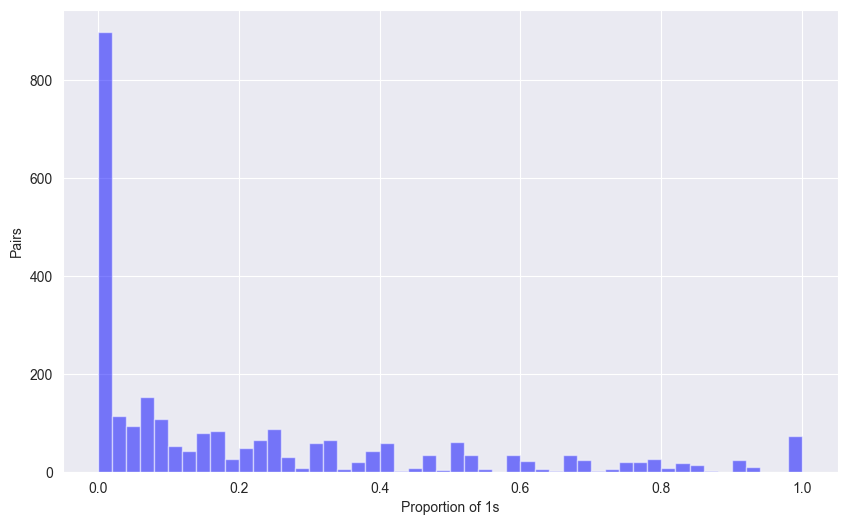

In [7]:
cliff_pivot_reset = cliff_pivot.reset_index()

plt.figure(figsize=(10, 6))
plt.hist(cliff_pivot_reset['proportion_of_1'].to_numpy(), color='blue', alpha=0.5, bins=50)
plt.xlabel('Proportion of 1s')
plt.ylabel('Pairs');

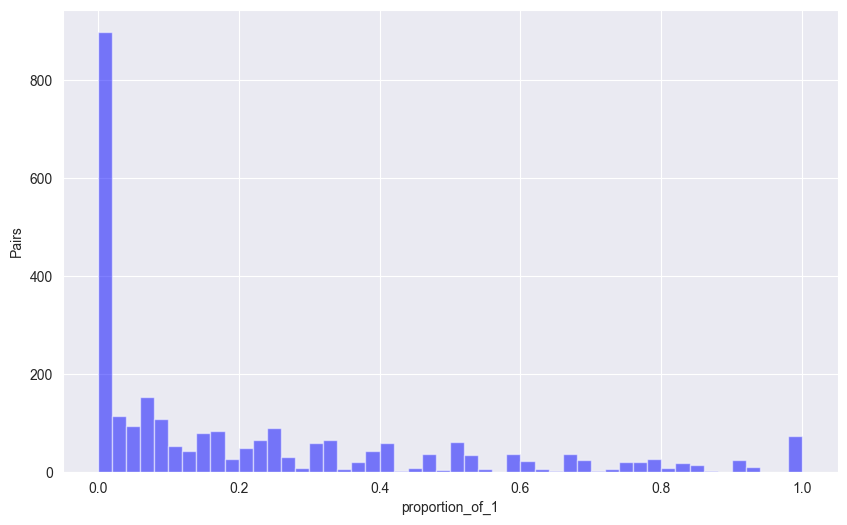

In [8]:
get_hist_prop(cliff_pivot, 'proportion_of_1')

In [6]:
len(cliff_pivot_reset), len(cliff_pivot_reset[cliff_pivot_reset['proportion_of_1'] == 0]), len(cliff_pivot_reset[cliff_pivot_reset['proportion_of_1'] == 1])

(2627, 795, 72)

In [7]:
len(cliff_pivot_reset[(cliff_pivot_reset['proportion_of_1'] != 0) & (cliff_pivot_reset['proportion_of_1'] != 1)])

1760

Out of 2627 drug pairs, 795 do not exhibit ACs (as it was expected) and 72 pairs does show AC exclusively. Moreover, there exists 1760 of compounds that demonstrate both non-AC and AC.

In [16]:
mv = majority_vote(cliff_pairs)
cliff_pivot_mv = mv.pivot_table(index=['drug1', 'drug2'], columns='cliff', aggfunc='size', fill_value=0)
cliff_pivot_mv['total_count'] = cliff_pivot_mv[0] + cliff_pivot_mv[1]
cliff_pivot_mv['proportion_of_1'] = cliff_pivot_mv[1] / cliff_pivot_mv['total_count']
cliff_pivot_mv

cliff                      0  1  total_count  proportion_of_1
drug1        drug2                                           
CHEMBL100102 CHEMBL327291  1  0            1              0.0
             CHEMBL95737   1  0            1              0.0
             CHEMBL97026   1  0            1              0.0
             CHEMBL97448   1  0            1              0.0
             CHEMBL97768   1  0            1              0.0
...                       .. ..          ...              ...
CHEMBL97448  CHEMBL97768   0  1            1              1.0
             CHEMBL97796   1  0            1              0.0
CHEMBL97768  CHEMBL97796   0  1            1              1.0
CHEMBL98721  CHEMBL99572   1  0            1              0.0
CHEMBL99743  CHEMBL104067  1  0            1              0.0

[2627 rows x 4 columns]

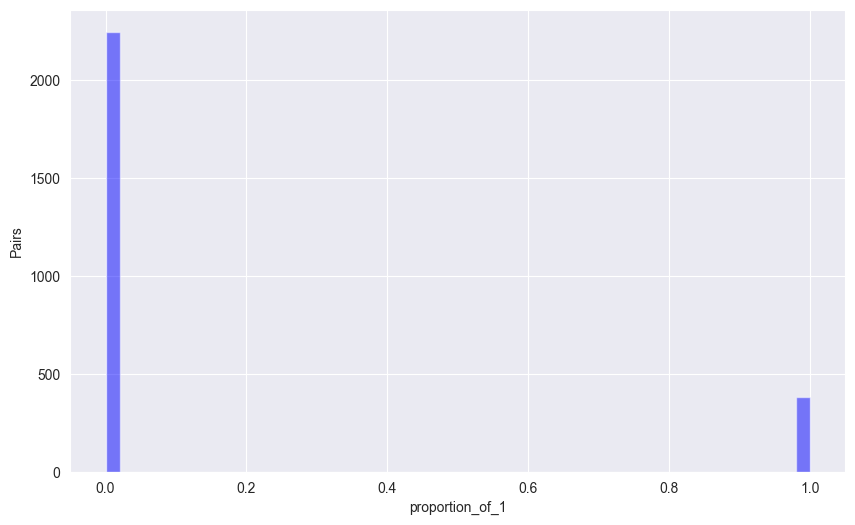

In [17]:
get_hist_prop(cliff_pivot_mv, 'proportion_of_1')

In [18]:
atleast_ac= at_least_once_AC(cliff_pairs)
cliff_pivot_ac = atleast_ac.pivot_table(index=['drug1', 'drug2'], columns='cliff', aggfunc='size', fill_value=0)
cliff_pivot_ac['total_count'] = cliff_pivot_ac[0] + cliff_pivot_ac[1]
cliff_pivot_ac['proportion_of_1'] = cliff_pivot_ac[1] / cliff_pivot_ac['total_count']
cliff_pivot_ac

cliff                      0  1  total_count  proportion_of_1
drug1        drug2                                           
CHEMBL100102 CHEMBL327291  1  0            1              0.0
             CHEMBL95737   1  0            1              0.0
             CHEMBL97026   1  0            1              0.0
             CHEMBL97448   1  0            1              0.0
             CHEMBL97768   1  0            1              0.0
...                       .. ..          ...              ...
CHEMBL97448  CHEMBL97768   0  1            1              1.0
             CHEMBL97796   1  0            1              0.0
CHEMBL97768  CHEMBL97796   0  1            1              1.0
CHEMBL98721  CHEMBL99572   0  1            1              1.0
CHEMBL99743  CHEMBL104067  0  1            1              1.0

[2627 rows x 4 columns]

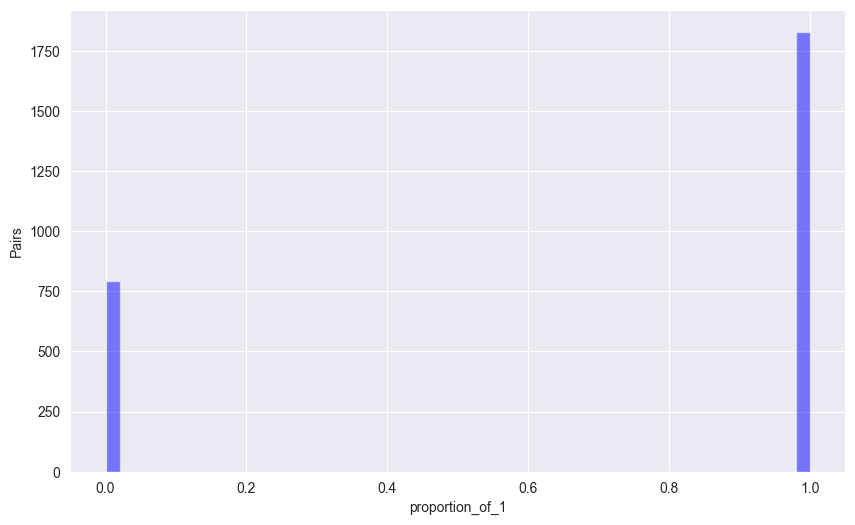

In [19]:
get_hist_prop(cliff_pivot_ac, 'proportion_of_1')

In [51]:
un1 = cliff_pairs[['drug1', 'drug2']].drop_duplicates()
un1

,drug1,drug2
0,CHEMBL1087421,CHEMBL1088633
1,CHEMBL206783,CHEMBL207037
2,CHEMBL206783,CHEMBL207246
3,CHEMBL206783,CHEMBL207584
4,CHEMBL206783,CHEMBL207674
...,...,...
19116,CHEMBL1996176,CHEMBL86755
20272,CHEMBL383264,CHEMBL1981133
24434,CHEMBL1981133,CHEMBL378963
55605,CHEMBL1991008,CHEMBL2002182


In [105]:
un2 = cliff_pairs[['drug1', 'drug2']].value_counts()
un2

drug1          drug2        
CHEMBL210928   CHEMBL210963     158
CHEMBL210963   CHEMBL378627     157
CHEMBL210928   CHEMBL378627     157
CHEMBL1991678  CHEMBL1996500    152
CHEMBL1980297  CHEMBL1989708    145
                               ... 
CHEMBL1987143  CHEMBL1973795      2
CHEMBL1979933  CHEMBL242237       2
CHEMBL360847   CHEMBL432130       1
CHEMBL1981133  CHEMBL378963       1
CHEMBL1970950  CHEMBL242237       1
Name: count, Length: 2627, dtype: int64

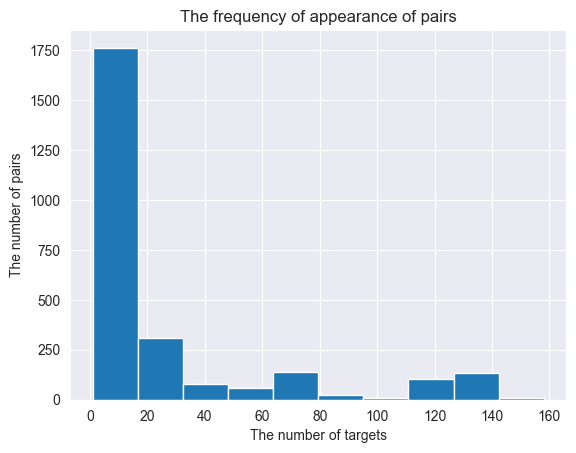

In [137]:
plt.hist(un2)
plt.title('The frequency of appearance of pairs')
plt.xlabel('The number of targets')
plt.ylabel('The number of pairs');

In [53]:
un3 = cliff_pairs[['drug1', 'drug2', 'target']].value_counts()
un3

drug1          drug2          target
CHEMBL100102   CHEMBL327291   O94806    1
CHEMBL1984206  CHEMBL209534   P22607    1
                              P31749    1
                              P29597    1
                              P29317    1
                                       ..
CHEMBL1967116  CHEMBL1974254  P06493    1
                              P06241    1
                              P06239    1
                              P06213    1
CHEMBL99743    CHEMBL104067   Q15139    1
Name: count, Length: 80517, dtype: int64

In [87]:
un4 = cliff_pairs[['drug1', 'drug2', 'cliff']].value_counts()
un4

drug1          drug2          cliff
CHEMBL210928   CHEMBL210963   0        158
CHEMBL210963   CHEMBL378627   0        157
CHEMBL210928   CHEMBL378627   0        157
CHEMBL1991678  CHEMBL1996500  0        151
CHEMBL377408   CHEMBL424872   0        140
                                      ... 
CHEMBL1242114  CHEMBL1242198  1          1
CHEMBL1242113  CHEMBL1242114  1          1
CHEMBL210032   CHEMBL2006567  1          1
CHEMBL1242109  CHEMBL1242114  1          1
CHEMBL99743    CHEMBL104067   1          1
Name: count, Length: 4387, dtype: int64

In [114]:
size_per_target = cliff_pairs.groupby('target').size()
size_per_target

target
O00141     81
O00311    371
O00329    894
O00418    175
O00444    373
         ... 
Q9Y243    443
Q9Y463     87
Q9Y478     91
Q9Y4K4    407
Q9Y6M4    248
Length: 222, dtype: int64

In [115]:
min(size_per_target), max(size_per_target)

(1, 1699)

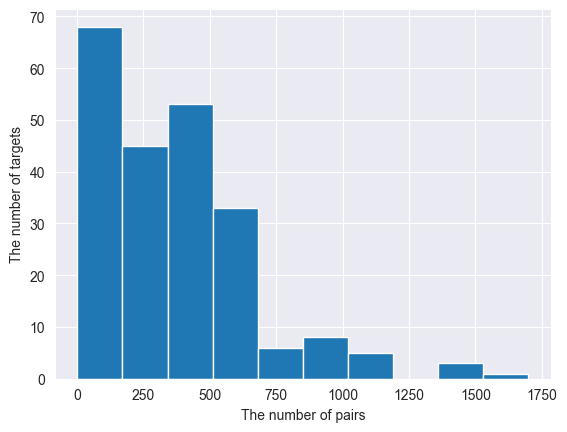

In [116]:
plt.hist(size_per_target)
plt.xlabel('The number of pairs')
plt.ylabel('The number of targets');

In [99]:
cliff_pairs['cliff'].value_counts()

cliff
0    70601
1     9916
Name: count, dtype: int64

In [6]:
cliff_pairs.to_csv('../analysis/morgan_cnn_kiba_cliff_pairs.csv', index=False)

In [4]:
cliff_pairs = pd.read_csv('../analysis/morgan_cnn_kiba_cliff_pairs.csv')

In [ ]:
cliff_pairs

In [6]:
cliff_pairs_nodup = cliff_pairs.drop_duplicates()

In [ ]:
cliff_pairs_nodup[cliff_pairs_nodup.cliff == 1]

In [8]:
drugs = load(open('../data/KIBA/SMILES.txt'))

In [ ]:
cliff_pairs_nodup['smiles1'] = cliff_pairs_nodup.drug1.apply(drugs.__getitem__)
cliff_pairs_nodup['smiles2'] = cliff_pairs_nodup.drug2.apply(drugs.__getitem__)

In [ ]:
cliff_pairs_nodup

In [12]:
cliff_pairs_nodup_split_random = split_data(cliff_pairs_nodup, split='random')

In [ ]:
cliff_pairs_nodup_split_random[cliff_pairs_nodup_split_random.split == 0]

In [25]:
cliff_pairs_nodup_split_random.to_csv('../analysis/kiba_cliff_pairs_ta_1_ts_0.9_random.csv', index=False)

In [18]:
cliff_pairs_nodup_split_cb = split_data(cliff_pairs_nodup, split='compound-based')

In [ ]:
cliff_pairs_nodup_split_cb[cliff_pairs_nodup_split_cb.split == 2]

In [24]:
cliff_pairs_nodup_split_cb.to_csv('../analysis/kiba_cliff_pairs_ta_1_ts_0.9_cb.csv', index=False)